In [102]:
import FundamentalAnalysis as fa
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [103]:
import yfinance as yf
import datetime
import time

# initialization

In [104]:
api_key = '3b6b429bcaa336eb655a960d8f4b2279'
# a9fd2572cb19c18fff9c003198eb3947
# 3b6b429bcaa336eb655a960d8f4b2279
# 076461d7fd8f09fce5671912ff9ac6c2

In [105]:
companies = fa.available_companies(api_key)

# Metrics description

In [106]:
key_metricas_selected_metrics = [
    'revenuePerShare',
    'netIncomePerShare',
    'operatingCashFlowPerShare',
    'freeCashFlowPerShare',
    'cashPerShare',
    'bookValuePerShare',
    'tangibleBookValuePerShare',
    'shareholdersEquityPerShare',
    'interestDebtPerShare',
    'marketCap',
    'enterpriseValue',
    
]
financial_ratio_metrics = [
    'cashRatio', # company's total cash and cash equivalents to its current liabilities
    'currentRatio', # ability to pay short-term obligations or those due within one year
    'operatingCycle', # the average period of time required for a business to make an initial outlay of cash to produce goods, 
        # sell the goods, and receive cash from customers in exchange for the goods
    'daysOfPayablesOutstanding', # time (in days) that a company takes to pay its bills and invoices to its trade creditors
    'cashConversionCycle', # time (measured in days) it takes for a company to convert its 
        # investments in inventory and other resources into cash flows from sales
    'grossProfitMargin', # amount of money left over from product sales after subtracting the cost of goods sold
    'operatingProfitMargin', # profit a company makes on a dollar of sales after paying for variable costs of production
    'netProfitMargin', # profit is generated as a percentage of revenue
    'returnOnAssets', # profitable a company is in relation to its total assets
    'returnOnCapitalEmployed', # dividing net operating profit, or earnings before interest and taxes (EBIT), by capital employed
]

In [107]:
def get_financial_metrics(ticker):
    end = datetime.datetime(2021,8,11)
    start = datetime.datetime(2015,10,11)
    
    try:
        key_metrics_annually = fa.key_metrics(ticker, api_key, period="annual")[['2021', '2015']].T
        key_metrics_df = key_metrics_annually[key_metricas_selected_metrics]

        financial_ratios_annually = fa.financial_ratios(ticker, api_key, period="annual")[['2021', '2015']].T
        financial_ratios_df = financial_ratios_annually[financial_ratio_metrics]
    except:
        key_metrics_annually = fa.key_metrics(ticker, api_key, period="annual")[['2022', '2015']]
        key_metrics_annually.columns = ['2021', '2015']
        key_metrics_annually=key_metrics_annually[['2021', '2015']].T
        key_metrics_df = key_metrics_annually[key_metricas_selected_metrics]

        financial_ratios_annually = fa.financial_ratios(ticker, api_key, period="annual")[['2022', '2015']]
        financial_ratios_annually.columns = ['2021', '2015']
        financial_ratios_annually=financial_ratios_annually[['2021', '2015']].T
        financial_ratios_df = financial_ratios_annually[financial_ratio_metrics]
        
    
    stock = yf.download(ticker, start=start, end=end, interval='3mo').dropna()
    
    price_start = (stock.iloc[0][1]+ stock.iloc[0][2])/ 2
    price_finish = (stock.iloc[-1][1]+ stock.iloc[-1][2])/ 2
    print(price_start, price_finish)
    
    result = pd.concat([financial_ratios_df, key_metrics_annually], axis=1)
    result['ticker'] = ticker
    result['price'] = [price_finish, price_start]
    return result

# Collecting companies tickets

In [108]:
def get_sp500() -> list:
    print("Loading S&P 500")
    payload=pd.read_html('https://web.archive.org/web/20150218093150/https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_df = payload[1][['Ticker symbol']]
    symbols = sp500_df['Ticker symbol'].values.tolist()
    np.random.shuffle(symbols)
    return symbols

In [109]:
def read_data():
    print("Reading companies.csv")
    try:
        result_df_original = pd.read_csv("companies.csv")
        result_df_original = result_df_original.loc[:,~result_df_original.columns.duplicated()]
    except:
        result_df_original = pd.DataFrame([])
    return result_df_original

In [110]:
def collect_tickers_data(result_df_original, symbols, number_of_symbols):
    i=0
    for symbol in symbols:
        i+=1
        if i == number_of_symbols:
            break
        if not result_df_original.empty and symbol in result_df_original['ticker'].values:
            continue
        try:
            current_metrics = get_financial_metrics(symbol)
            current_metrics = current_metrics.loc[:,~current_metrics.columns.duplicated()]
            current_metrics = current_metrics.reset_index().rename(columns = {'index':'date'})
            if result_df_original.empty:
                result_df_original = current_metrics
            else:
                result_df_original = pd.concat(
                    [result_df_original, current_metrics],
                    axis=0,
                    ignore_index=False
                )
            print(f'Collected {symbol}')
        except Exception as e:
            print("skipping symbol")
    print("Saving data to companies.csv")
    result_df_original.to_csv("companies.csv", index=False)
    return result_df_original

In [111]:
def collect_data(number_of_symbols):
    result_df_original = read_data()
    symbols = get_sp500()
    data = collect_tickers_data(result_df_original, symbols, number_of_symbols)
    return data

In [112]:
def prepare_data(result_df):
    result_df = result_df.convert_dtypes()
    result_df['date'] = result_df['date'].astype(int)
    result_df = result_df.sort_values(by='date')
    result_df['diff'] = result_df.groupby(['ticker'])['price'].diff().values
    return result_df

In [113]:
def normalization(result_df):
    result_df = result_df.drop(columns=['ticker'])
    result_df = result_df.drop(columns="period")
    result_df['percent_growth'] = result_df['diff'] / result_df['price']
    result_df = result_df.loc[:,~result_df.columns.duplicated()]
    sliced = result_df.loc[:, "cashRatio":"capexPerShare"]
    sliced= (
        sliced-sliced.mean()
    )/sliced.std()
    result_df[sliced.columns] = sliced.values
    result_df = result_df.fillna(0)
    return result_df

# Collecting

In [114]:
r = collect_data(30)

Reading companies.csv
Loading S&P 500
skipping symbol
[*********************100%***********************]  1 of 1 completed
82.27000045776367 220.84000396728516
Collected UNP
[*********************100%***********************]  1 of 1 completed
64.20249938964844 164.13500213623047
Collected NKE
[*********************100%***********************]  1 of 1 completed
43.26499938964844 19.72000026702881
Collected M
[*********************100%***********************]  1 of 1 completed
39.375 42.21999931335449
Collected KR
skipping symbol
skipping symbol
skipping symbol
[*********************100%***********************]  1 of 1 completed
79.40999984741211 74.59499931335449
Collected EOG
[*********************100%***********************]  1 of 1 completed
153.38999938964844 197.96500396728516
Collected MMM
skipping symbol
[*********************100%***********************]  1 of 1 completed
149.60499572753906 363.61500549316406
Collected MLM
[*********************100%***********************]  1 of 

In [126]:
result_df = prepare_data(r)

In [127]:
result_df = normalization(result_df)

# Feature engineering

# target transform

In [128]:
train_data = (
    result_df[result_df['date']==2015]
    .drop(columns=['percent_growth', 'date' ,'price', 'diff'])
    .values
)

In [129]:
target = (result_df[result_df['date']==2021]['percent_growth'] > 0.7).astype('int').values

In [130]:
train_data.shape

(176, 66)

In [131]:
sum(target)

55

## GRID SEARCH

In [234]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [133]:
pca = PCA(n_components=5)
rf = RandomForestClassifier()
kf = StratifiedKFold(n_splits=7, shuffle=True)
poly = PolynomialFeatures(2)
selector = SelectKBest(f_classif, k=10)

In [143]:
parameters_RF = {
    "rf__class_weight": ("balanced", "balanced_subsample"),
    "rf__max_features": ("auto", "log2"),
    "pca__n_components": [13, 16, 18, 20, 22],
    "selector__k": [8, 10]
}

In [144]:
pipe = Pipeline(steps=[("pca", pca), ("poly", poly), ("selector", selector), ("rf", rf)])

In [145]:
search = GridSearchCV(pipe, parameters_RF, n_jobs=2, verbose=1, scoring='f1', cv=kf)

In [146]:
search.fit(train_data, target)

Fitting 7 folds for each of 40 candidates, totalling 280 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA(n_components=5)),
                                       ('poly', PolynomialFeatures()),
                                       ('selector', SelectKBest()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'pca__n_components': [13, 16, 18, 20, 22],
                         'rf__class_weight': ('balanced', 'balanced_subsample'),
                         'rf__max_features': ('auto', 'log2'),
                         'selector__k': [8, 10]},
             scoring='f1', verbose=1)

In [147]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.334):
{'pca__n_components': 13, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 'auto', 'selector__k': 10}


In [200]:
search.best_params_#.pop('rf__class_weight', None).pop('rf__max_features', None)

{'pca__n_components': 13, 'rf__max_features': 'auto', 'selector__k': 10}

# Best params

In [148]:
n_components = 13
class_weight = 'balanced_subsample'
max_features = 'auto'
selector_k = 10

In [205]:
pca = PCA(n_components=13)
poly = PolynomialFeatures(2)
selector = SelectKBest(f_classif, k=10)

In [206]:
# transform pipe
transform_pipe = Pipeline(steps=[("pca", pca), ("poly", poly), ("selector", selector)])

In [209]:
transformed_train_data = transform_pipe.fit_transform(
    train_data,
    y=target, 
)

In [212]:
train_data_upd = transformed_train_data

# Machine Learning

In [221]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
i = 0
results = {
    'f1': [],
    'roc_auc': [],
    'random_f1': [],
    'random_auc': [],
}
for i in range(10):
    for train_index, test_index in kf.split(train_data_upd, target):
        X_train, X_test = train_data_upd[train_index], train_data_upd[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf = RandomForestClassifier(random_state=i, class_weight='balanced_subsample', max_features='auto')
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        random_data = np.random.choice([1, 0], y_test.shape[0], p=[0.30, 1-0.30])
        results['f1'].append(f1_score(prediction, y_test))
        results['random_f1'].append(f1_score(random_data, y_test))
        try:
            roc_auc = roc_auc_score(prediction, y_test)
            results['roc_auc'].append(roc_auc)
            random_score = roc_auc_score(random_data, y_test)
            results['random_auc'].append(random_score)
        except ValueError:
            pass

In [222]:
np.mean(results['roc_auc'])

0.670281549298289

In [224]:
np.mean(results['random_auc'])

0.5038307897428672

In [225]:
np.mean(results['f1'])

0.37716489066489073

In [226]:
np.mean(results['random_f1'])

0.2960096015096014

# Roc Curve

In [228]:
X_train, x_test, Y_train, y_test = train_test_split(train_data_upd, target)

In [229]:
clf = RandomForestClassifier(class_weight='balanced_subsample', max_features='auto')

In [230]:
clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample')

In [231]:
prediction = clf.predict(x_test)

In [237]:
import matplotlib.pyplot as plt

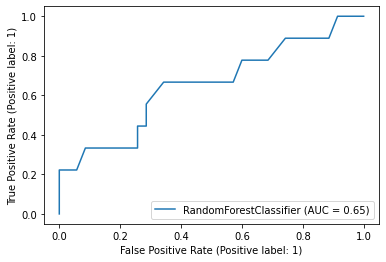

In [238]:
plot_roc_curve(clf, x_test, y_test, )
plt.show()